<a href="https://colab.research.google.com/github/marcellinusc/solar-radiation/blob/data-prep/ml_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Initialization

In [0]:
#@title Run on TensorFlow 2.x

%tensorflow_version 2.x
from __future__ import absolute_import, division
from __future__ import print_function, unicode_literals

In [85]:
#@title Import relevant modules

import re
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from datetime import datetime
from tensorflow.keras import layers
from matplotlib import pyplot as plt

# The following lines adjust the granularity of reporting. 
pd.options.display.max_rows = 20
pd.options.display.float_format = "{:.1f}".format

print('Modules Imported')

Modules Imported


##Data Preparation

In [86]:
#@title Load raw dataset
data = pd.read_csv('https://raw.githubusercontent.com/marcellinusc/solar-radiation/data-prep/datasets.csv')
print('Length of raw dataset:', str(len(data)))

Length of raw dataset: 32686


In [87]:
#@title Check for null values & show data types

print('NULL DATA')
print('===================')
print(data.isnull().sum())
print('\nDATA TYPES')
print('==========================================')
print(data.info())

NULL DATA
UNIXTime         0
Date             0
Time             0
Radiation        0
Temperature      0
Pressure         0
Humidity         0
WindDirection    0
WindSpeed        0
Sunrise          0
Sunset           0
dtype: int64

DATA TYPES
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   UNIXTime       32686 non-null  int64  
 1   Date           32686 non-null  object 
 2   Time           32686 non-null  object 
 3   Radiation      32686 non-null  float64
 4   Temperature    32686 non-null  int64  
 5   Pressure       32686 non-null  float64
 6   Humidity       32686 non-null  int64  
 7   WindDirection  32686 non-null  float64
 8   WindSpeed      32686 non-null  float64
 9   Sunrise        32686 non-null  object 
 10  Sunset         32686 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 2.7+ MB
None


In [88]:
#@title Deal with missing values 

# Drop the rows where at least one element is missing
data.dropna()

# Copy clean dataset as original back up
data_clean = data.copy()

print('Length of clean datset:', str(len(data)))
data.describe()

Length of clean datset: 32686


,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection,WindSpeed
count,32686.0,32686.0,32686.0,32686.0,32686.0,32686.0,32686.0
mean,1478047264.9,207.1,51.1,30.4,75.0,143.5,6.2
std,3005036.6,315.9,6.2,0.1,26.0,83.2,3.5
min,1472724008.0,1.1,34.0,30.2,8.0,0.1,0.0
25%,1475546497.5,1.2,46.0,30.4,56.0,82.2,3.4
50%,1478026069.5,2.7,50.0,30.4,85.0,147.7,5.6
75%,1480480128.0,354.2,55.0,30.5,97.0,179.3,7.9
max,1483264501.0,1601.3,71.0,30.6,103.0,359.9,40.5


In [0]:
#@title Add synthetic parameter whether the sun is up or down

data['Daylight'] = [data['Time'].values[x] > data['Sunrise'].values[x]
            and data['Time'].values[x] < data['Sunset'].values[x]
            for x in range(len(data))]
data['Daylight'] = data['Daylight'].astype('float')

conversion = pd.DataFrame()

conversion['Time'] = pd.to_datetime(data['Time'], format='%H:%M:%S')
conversion['Sunrise'] = pd.to_datetime(data['Sunrise'], format='%H:%M:%S')
conversion['Sunset'] = pd.to_datetime(data['Sunset'], format='%H:%M:%S')

conversion['Daylength'] = (conversion['Sunset'] - conversion['Sunrise']) / pd.to_timedelta(1, unit='S')
conversion['Peak'] = conversion['Daylength'] / 2
conversion['Position'] = (conversion['Time'] - conversion['Sunrise']) / pd.to_timedelta(1, unit='S')

# Set 'Daylight' parameter as continuous values 
# 'Daylight' = 1 if the sun is at noon
# 'Daylight' = 0 if the sun has yet risen or already set
for x in range(len(data)):
  if data['Daylight'].values[x] == 1.0:
    data['Daylight'].values[x] = 1 - (abs(conversion['Position'].values[x] - conversion['Peak'].values[x]) / conversion['Peak'].values[x])

In [0]:
#@title Deal with imbalanced data

# Clean dataset from daylight value of 0
data = data[data.Daylight != 0]

In [91]:
#@title Convert UNIX time format to UTC

#Merge columns 'Date' and 'Time'
x = [i.replace('12:00:00 AM', '') for i in data['Date']]

data['DateTime'] = x + data['Time']
data['DateTime'] = pd.to_datetime(data['DateTime'])
data["TimeConversion"] = pd.to_datetime(data["Time"], format="%H:%M:%S")

# Get the month of the year and the day of the month
data["Month"] = pd.to_datetime(data["UNIXTime"].astype(int),
                               unit="s").dt.month
data["Day"] = pd.to_datetime(data["UNIXTime"].astype(int),
                             unit="s").dt.day 

# Get the hour and the minute of the day
data["Hour"] = pd.to_datetime(data["TimeConversion"],
                              format="%H:%M:%S").dt.hour

print('UNIX converted to UTC time format')

UNIX converted to UTC time format


(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200., 1400.,
        1600., 1800.]), <a list of 11 Text major ticklabel objects>)

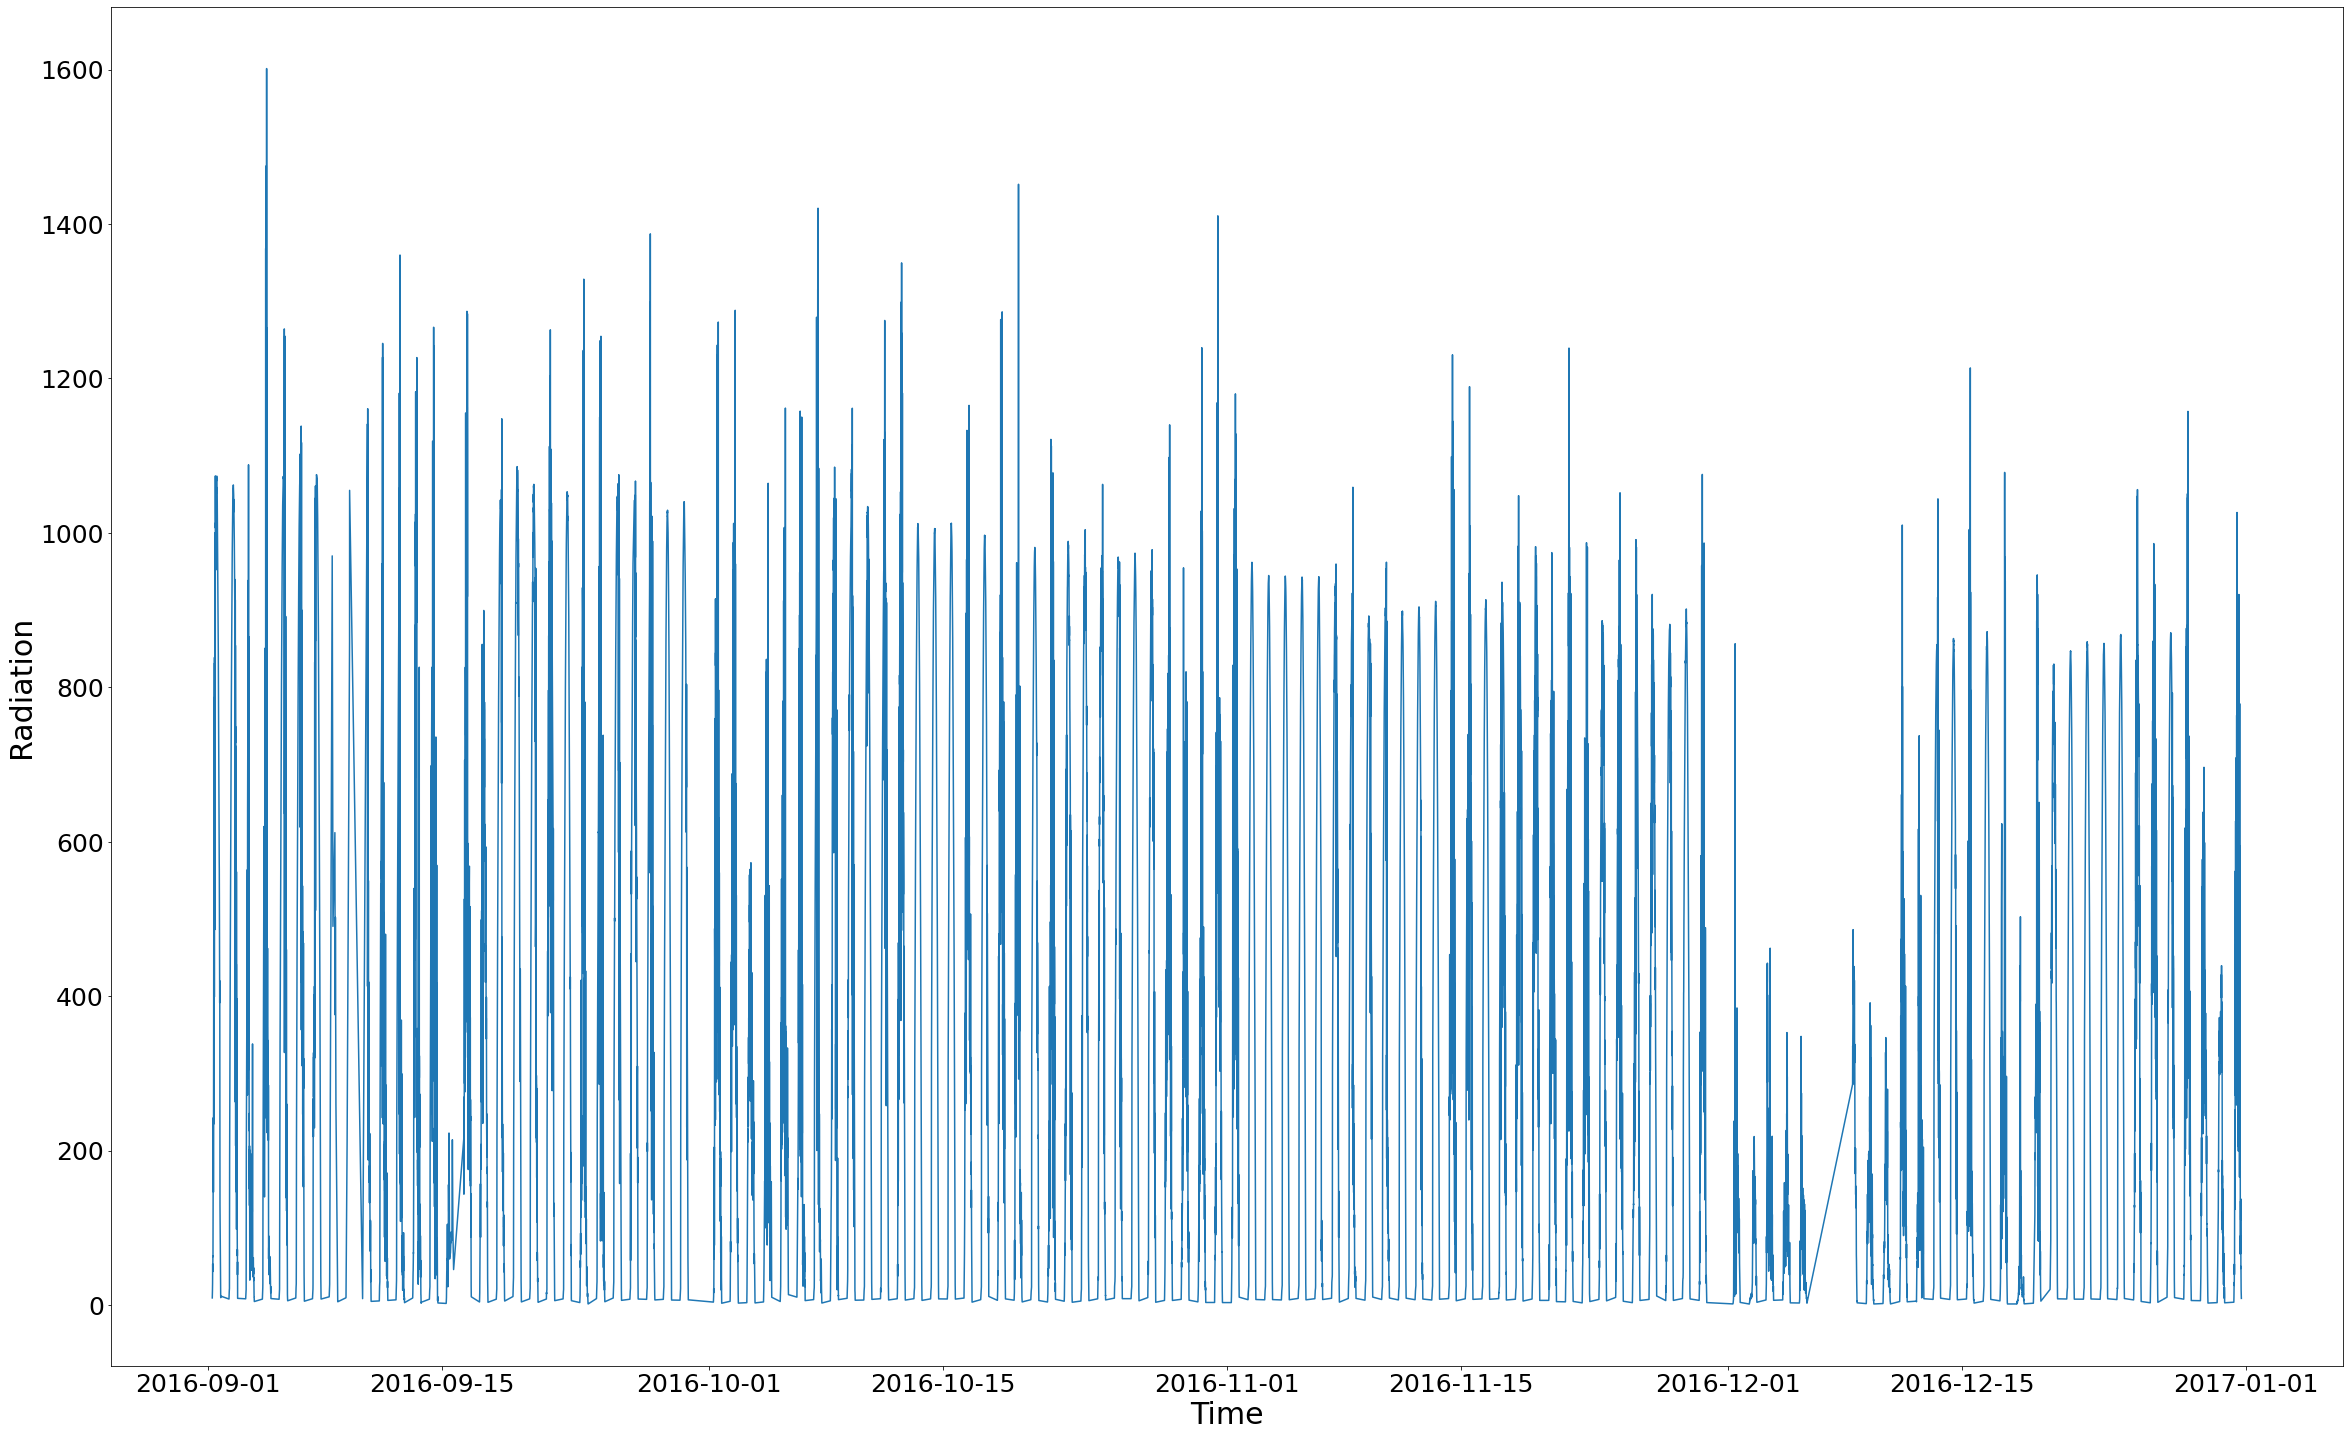

In [92]:
#@title Plot 'Radiation' from September 2016 to January 2017

data_viz = data.sort_values('DateTime', ascending=True)
data_viz.head(15)

plt.figure(figsize = (40,25))
plt.rcParams['agg.path.chunksize'] = 10000
plt.plot(data_viz['DateTime'], data_viz['Radiation'])

plt.xlabel('Time', fontsize = 30)
plt.xticks(fontsize = 25)
plt.ylabel('Radiation', fontsize = 30)
plt.yticks(fontsize = 25)

In [93]:
#@title Divide clean dataset into training set and test set

# Sort dataset in descending order from the latest to the earliest
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values(by=['Date', 'Time'], ascending=False)

# Percentage of dataset to be considered as test set
test_split = 0.1
data_test = data[:][0:round((len(data)*test_split))]
data_train = data[:][round((len(data)*test_split)):]

# Shuffle dataset before splitting
data_train = data_train.reindex(np.random.permutation(data_train.index))

print('Length of training dataset:', str(len(data_train)),
      '\nLength of test set length:', str(len(data_test)))

Length of training dataset: 14047 
Length of test set length: 1561


In [117]:
#@title Normalize values to Z-score

data_mean = data.select_dtypes(include=['float64', 'int64']).mean()
data_std = data.select_dtypes(include=['float64', 'int64']).std()

# Calculate the Z-scores of each column in the training dataset:
data_train_norm = (data_train.select_dtypes(include=['float64', 'int64']) 
                  - data_mean) / data_std

# Calculate the Z-scores of each column in the test dataset:
data_test_norm = (data_test.select_dtypes(include=['float64', 'int64'])
                 - data_mean) / data_std

frames = [data_train_norm, data_test_norm]
data_norm = pd.concat(frames)

print("Values normalized")

parameters = data_norm[['Radiation', 'Temperature', 'Pressure', 'Humidity',
                      'WindDirection', 'WindSpeed', 'Month', 'Day', 'Hour',
                      'Daylight']].copy()

from google.colab import files
parameters.to_csv('datasets_prep.csv')

parameters.describe()

Values normalized


,Radiation,Temperature,Pressure,Humidity,WindDirection,WindSpeed,Month,Day,Hour,Daylight
count,15608.0,15608.0,15608.0,15608.0,15608.0,15608.0,15608.0,15608.0,15608.0,15608.0
mean,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
min,-1.3,-3.2,-4.3,-2.6,-1.2,-1.7,-7.8,-1.7,-1.7,-1.7
25%,-1.0,-0.8,-0.4,-0.7,-0.8,-0.8,-0.4,-0.8,-0.8,-0.9
50%,-0.2,0.2,0.1,0.3,-0.3,-0.2,-0.4,0.0,0.1,0.0
75%,0.9,0.8,0.7,0.9,0.4,0.4,0.4,0.8,1.0,0.9
max,3.5,2.6,2.5,1.1,2.2,9.4,1.3,1.7,1.9,1.7


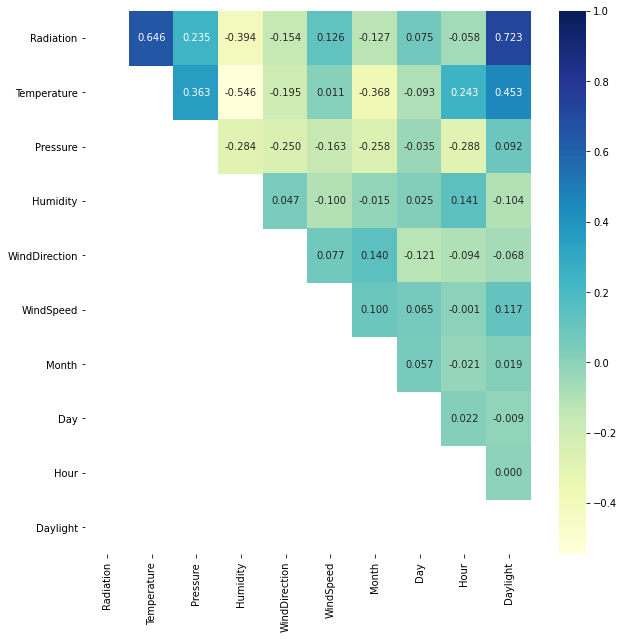

In [95]:
#@title Show correlation between parameters

plt.figure(figsize = (10,10))
mask = np.tril(np.ones_like(parameters.corr(), dtype=np.bool))
sns.heatmap(parameters.corr(), mask=mask, cmap="YlGnBu", annot = True, fmt = '.3f')

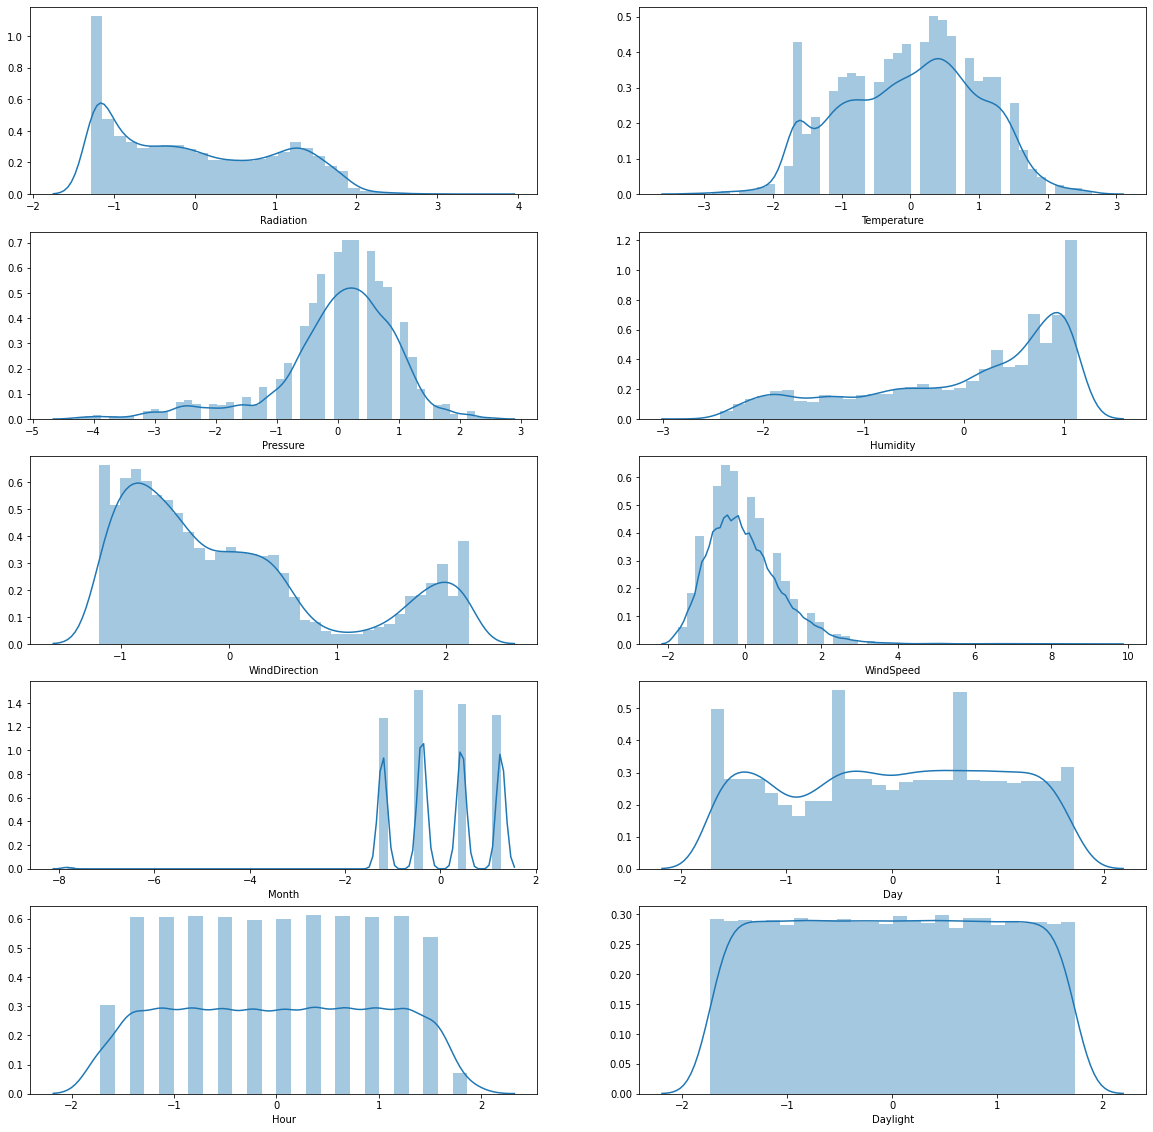

In [96]:
#@title Show density histogram for each parameter
(
    fig,
    (
        (ax1, ax2),
        (ax3, ax4),
        (ax5, ax6),
        (ax7, ax8),
        (ax9, ax10),
    ),
) = plt.subplots(5, 2, figsize=(20, 20))

sns.distplot(parameters['Radiation'], ax=ax1)
sns.distplot(parameters['Temperature'], ax=ax2)
sns.distplot(parameters['Pressure'], ax=ax3)
sns.distplot(parameters['Humidity'], ax=ax4)
sns.distplot(parameters['WindDirection'], ax=ax5)
sns.distplot(parameters['WindSpeed'], ax=ax6)
sns.distplot(parameters['Month'], ax=ax7)
sns.distplot(parameters['Day'], ax=ax8)
sns.distplot(parameters['Hour'], ax=ax9)
sns.distplot(parameters['Daylight'], ax=ax10)

[]

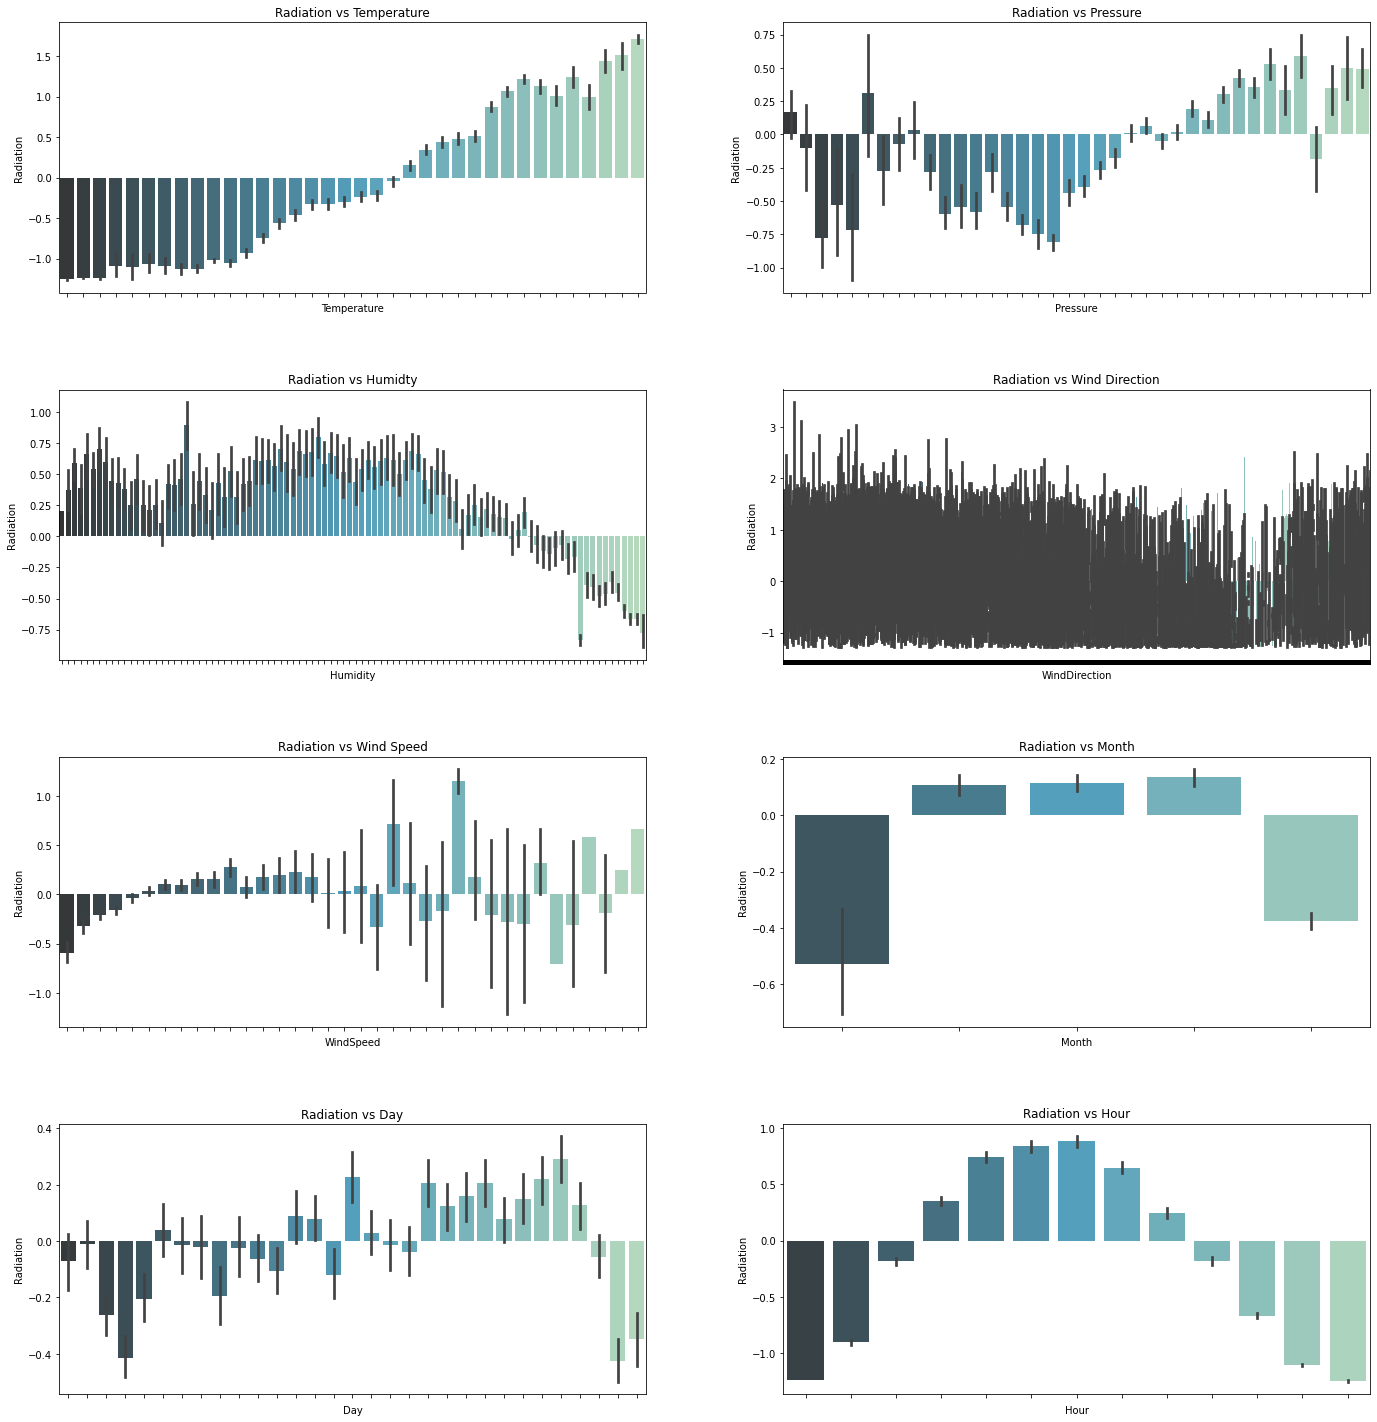

In [107]:
#@title Show barplot between label and other parameter
(
    fig,
    (
        (ax1, ax2),
        (ax3, ax4),
        (ax5, ax6),
        (ax7, ax8),
    ),
) = plt.subplots(4, 2, figsize=(20, 20))

ax1.set_title("Radiation vs Temperature")
sns.barplot(x="Temperature", y="Radiation",
            data=parameters, palette="GnBu_d", ax=ax1)
ax2.set_title("Radiation vs Pressure")
sns.barplot(x="Pressure", y="Radiation",
            data=parameters, palette="GnBu_d", ax=ax2)
ax3.set_title("Radiation vs Humidty")
sns.barplot(x="Humidity", y="Radiation",
            data=parameters, palette="GnBu_d", ax=ax3)
ax4.set_title("Radiation vs Wind Direction")
sns.barplot(x="WindDirection", y="Radiation",
            data=parameters, palette="GnBu_d", ax=ax4)
ax5.set_title("Radiation vs Wind Speed")
sns.barplot(x="WindSpeed", y="Radiation",
            data=parameters, palette="GnBu_d", ax=ax5)
ax6.set_title("Radiation vs Month")
sns.barplot(x="Month", y="Radiation",
            data=parameters, palette="GnBu_d", ax=ax6)
ax7.set_title("Radiation vs Day")
sns.barplot(x="Day", y="Radiation",
            data=parameters, palette="GnBu_d", ax=ax7)
ax8.set_title("Radiation vs Hour")
sns.barplot(x="Hour", y="Radiation",
            data=parameters, palette="GnBu_d", ax=ax8)

# Adjust spacing between subplots
fig.tight_layout(w_pad=3.0, h_pad=5.0)

# Hide x-axis values
ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax3.set_xticklabels([])
ax4.set_xticklabels([])
ax5.set_xticklabels([])
ax6.set_xticklabels([])
ax7.set_xticklabels([])
ax8.set_xticklabels([])

In [98]:
#@title Represent features as floating-point values

feature_columns = []

temperature = tf.feature_column.numeric_column("Temperature")
feature_columns.append(temperature)

pressure = tf.feature_column.numeric_column("Pressure")
feature_columns.append(pressure)

humidity = tf.feature_column.numeric_column("Humidity")
feature_columns.append(humidity)

wdirection = tf.feature_column.numeric_column("WindDirection")
feature_columns.append(wdirection)

#wspeed = tf.feature_column.numeric_column("WindSpeed")
#feature_columns.append(wspeed)

#sunrise = tf.feature_column.numeric_column("Sunrise")
#feature_columns.append(sunrise)

#sunset = tf.feature_column.numeric_column("Sunset")
#feature_columns.append(sunset)

#month = tf.feature_column.numeric_column("Month")
#feature_columns.append(month)

#day = tf.feature_column.numeric_column("Day")
#feature_columns.append(day)

hour = tf.feature_column.numeric_column("Hour")
feature_columns.append(hour)

daylight = tf.feature_column.numeric_column("Daylight")
feature_columns.append(daylight)

# Convert the list of feature columns into a layer that 
# later will be fed into the model. 
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

print('Feature representations selected')

Feature representations selected


##Build Model: Linear Regression

In [99]:
#@title Define plotting function

"""Plot loss vs epoch in a graph"""
def plot_the_loss_curve(epochs, rmse_training, rmse_validation):
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Root Mean Squared Error')

  plt.plot(epochs[1:], rmse_training[1:], label='Training Loss')
  plt.plot(epochs[1:], rmse_validation[1:], label='Validation Loss')
  plt.legend()

  merged_rmse_lists = rmse_training[1:] + rmse_validation[1:]
  highest_loss = max(merged_rmse_lists)
  lowest_loss = min(merged_rmse_lists)
  delta = highest_loss - lowest_loss
  print(delta)

  top_of_y_axis = highest_loss + (delta * 0.05)
  bottom_of_y_axis = lowest_loss - (delta * 0.05)
  plt.ylim([bottom_of_y_axis, top_of_y_axis])
  plt.show()  

print('Plot function defined')

Plot function defined


In [100]:
#@title Define functions to create and train  model

"""Create and compile a simple linear regression model."""
def create_model(learning_rate, feature_layer):
  
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the layer containing the feature columns to the model.
  model.add(feature_layer)

  # Add one linear layer to the model to yield a simple linear regressor.
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,)))

  # Construct the layers into a model that TensorFlow can execute.
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=learning_rate),
                loss='mean_squared_error',
                metrics=[tf.keras.metrics.RootMeanSquaredError()])
  
  return model           

"""Feed a dataset into the model in order to train it."""
def train_model(model, dataset, epochs, batch_size,
                label_name, validation_split):

  # Split the dataset into features and label.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, validation_split=validation_split, 
                      shuffle=True)

  # Get details that will be useful for plotting the loss curve.
  epochs = history.epoch
  hist = pd.DataFrame(history.history)
  rmse = hist['root_mean_squared_error']

  return epochs, rmse, history.history   

print('Model defined')

Model defined


Epoch 1/100

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 0s 17ms/step - loss: 1.6669 - root_mean_squared_error: 1.2981 - val_loss: 1.3201 - val_root_mean_squared_error: 1.1480
Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 1.2010 - root_mean_squared_error: 1.0978 - val_loss: 1.0043 - val_root_mean_squared_error: 1.0016
Epoch 3/100
11/11 [==============================] - 0s 7ms/step - loss: 0.9077 - root_mean_squared_error: 0.9585 - val_loss: 0.7718 - val_root_mean_squared_error: 0

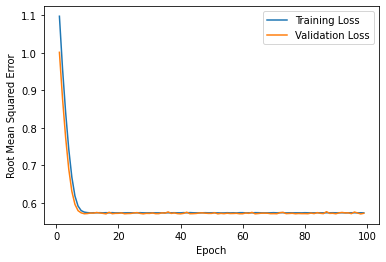


 Evaluate the linear regression model against the test set:
2/2 [==============================] - 0s 3ms/step - loss: 0.1557 - root_mean_squared_error: 0.4177


[0.15567606687545776, 0.4176912009716034]

In [101]:
#@title Train model

# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 100
batch_size = 1024
validation_split = 0.25
label_name = 'Radiation'

# Establish the model's topography.
model = create_model(learning_rate, feature_layer)

# Train the model on the normalized training set.
epochs, rmse, history = train_model(model, data_train_norm, epochs, batch_size,
                                    label_name, validation_split=validation_split)
plot_the_loss_curve(epochs, history['root_mean_squared_error'], 
                    history['val_root_mean_squared_error'])

test_features = {name:np.array(value) for name, value in data_test_norm.items()}
# Isolate the label
test_label = np.array(test_features.pop(label_name))
print('\n Evaluate the linear regression model against the test set:')
model.evaluate(x=test_features, y=test_label, batch_size=batch_size)

##Build Model: Deep Neural Net

In [0]:
#@title Define functions to create and train model

"""Create and compile a simple linear regression model."""
def create_model(my_learning_rate, my_feature_layer):
  
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the layer containing the feature columns to the model.
  model.add(my_feature_layer)

  # Describe the topography of the model by calling the tf.keras.layers.Dense
  # method once for each layer. We've specified the following arguments:
  #   * units specifies the number of nodes in this layer.
  #   * activation specifies the activation function (sigmoid).
  #   * name is just a string that can be useful when debugging.

  # Define the first hidden layer with x nodes.   
  model.add(tf.keras.layers.Dense(units=16, 
                                  activation='sigmoid',
                                  name='Hidden1'))
  
  # Define the second hidden layer with x nodes. 
  model.add(tf.keras.layers.Dense(units=8, 
                                  activation='sigmoid', 
                                  name='Hidden2'))
  # Define the second hidden layer with x nodes. 
  model.add(tf.keras.layers.Dense(units=4, 
                                  activation='sigmoid', 
                                  name='Hidden3'))
  # Define the output layer.
  model.add(tf.keras.layers.Dense(units=1,  
                                  name='Output'))                              
  
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

  return model

def train_model(model, dataset, epochs, label_name,
                batch_size, validation_split):
  """Train the model by feeding it data."""

  # Split the dataset into features and label.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, validation_split=validation_split, shuffle=True) 

  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch
  
  # To track the progression of training, gather a snapshot
  # of the model's root mean squared error at each epoch. 
  hist = pd.DataFrame(history.history)
  rmse = hist["root_mean_squared_error"]

  return epochs, rmse, history.history 

Epoch 1/1000
13/13 [==============================] - 0s 16ms/step - loss: 0.9820 - root_mean_squared_error: 0.9914 - val_loss: 0.9037 - val_root_mean_squared_error: 0.9554
Epoch 2/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.8362 - root_mean_squared_error: 0.9163 - val_loss: 0.6852 - val_root_mean_squared_error: 0.8357
Epoch 3/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.5768 - root_mean_squared_error: 0.7628 - val_loss: 0.4302 - val_root_mean_squared_error: 0.6680
Epoch 4/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.3989 - root_mean_squared_error: 0.6327 - val_loss: 0.3397 - val_root_mean_squared_error: 0.5928
Epoch 5/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.3494 - root_mean_squared_error: 0.5930 - val_loss: 0.3215 - val_root_mean_squared_error: 0.5767
Epoch 6/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.3420 - root_mean_squared_error: 0.5848 - val_loss: 0.3142 - val

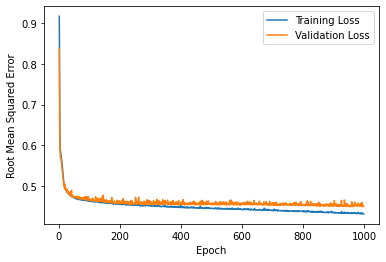


 Evaluate the linear regression model against the test set:
2/2 [==============================] - 0s 3ms/step - loss: 0.2228 - root_mean_squared_error: 0.5239


[0.22275438904762268, 0.5239031314849854]

In [103]:
#@title Train model
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 1000
batch_size = 1024
validation_split = 0.1
label_name = "Radiation"
 
# Establish the model's topography.
model = create_model(learning_rate, feature_layer)

# Train the model on the normalized training set.
epochs, rmse, history = train_model(model, data_train_norm, epochs, label_name, batch_size, 
                          validation_split)
plot_the_loss_curve(epochs, history["root_mean_squared_error"], 
                    history["val_root_mean_squared_error"])

test_features = {name:np.array(value) for name, value in data_test_norm.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the linear regression model against the test set:")
model.evaluate(x = test_features, y = test_label, batch_size=batch_size)

## Compare Prediction vs Actual Values

In [104]:
#@title Display random actual and predicted values from test set

prediction = model.predict(test_features, batch_size=1024)
prediction = [
    (prediction[i] * data_std["Radiation"]) + data_mean["Radiation"]
    for i in range(len(prediction))
]
rand = np.random.randint(0,len(prediction),20) # pick 20 random index

print('Compare the first 20 values between actual values and predicted values\n')
for i in rand:
  print('\n------------------', i, '-----------------------\n')
  print('Actual Value : ', data_test['Radiation'].values[i])
  print('Predicted Value : ', prediction[i])

Compare the first 20 values between actual values and predicted values


------------------ 565 -----------------------

Actual Value :  768.37
Predicted Value :  [843.18054]

------------------ 223 -----------------------

Actual Value :  303.28
Predicted Value :  [714.4612]

------------------ 846 -----------------------

Actual Value :  956.68
Predicted Value :  [654.4858]

------------------ 65 -----------------------

Actual Value :  542.66
Predicted Value :  [760.94214]

------------------ 715 -----------------------

Actual Value :  611.2
Predicted Value :  [804.18945]

------------------ 399 -----------------------

Actual Value :  90.52
Predicted Value :  [22.22409]

------------------ 270 -----------------------

Actual Value :  65.07
Predicted Value :  [14.615234]

------------------ 330 -----------------------

Actual Value :  367.2
Predicted Value :  [173.90402]

------------------ 704 -----------------------

Actual Value :  788.9
Predicted Value :  [664.12494]

---------

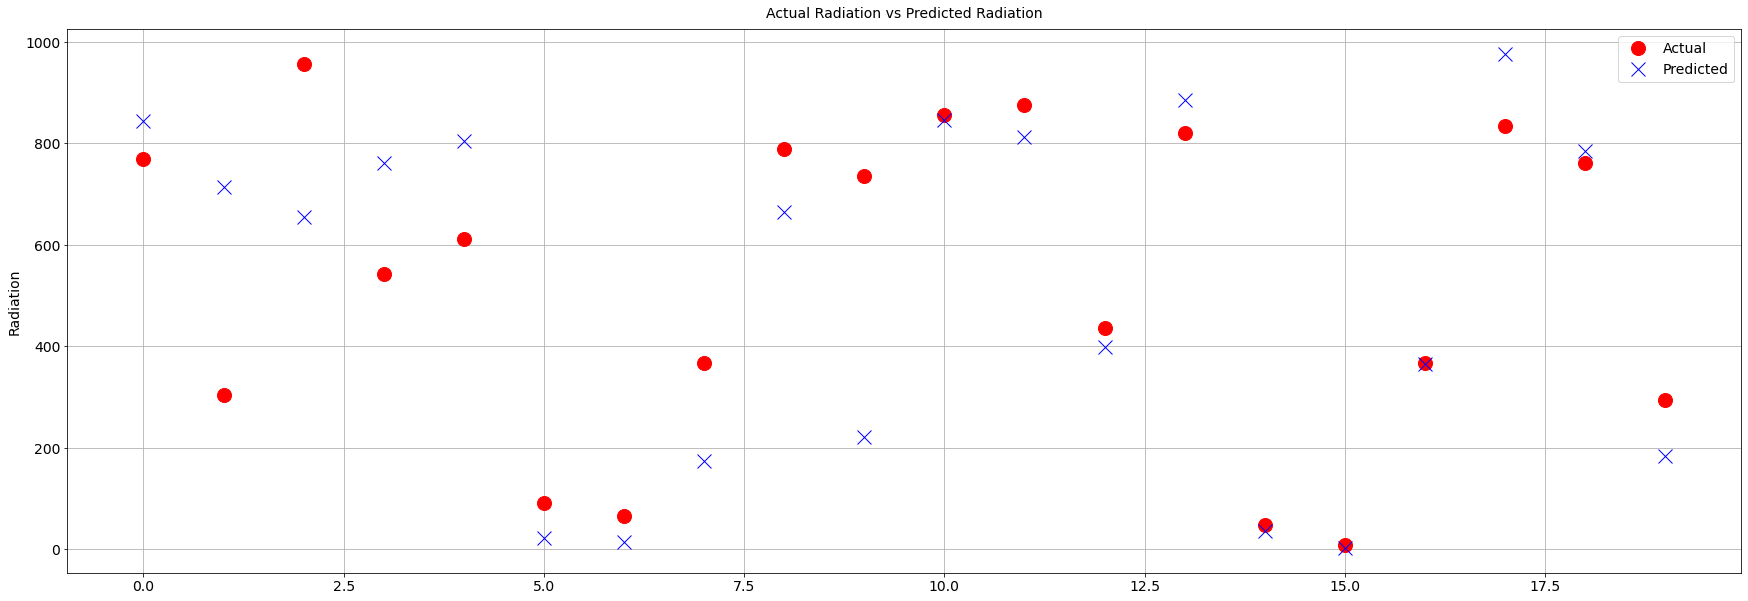

In [105]:
#@title Plot random values from test set

x_value = [i for i in range (20)]
plt.figure(figsize = (30,10))
plt.plot(x_value, data_test['Radiation'].values[rand], 'ro',
         markersize=14 ,label='Actual')
plt.plot(x_value, [prediction[i] for i in rand], 'bx',
         markersize=14, label='Predicted')
plt.legend(prop={'size': 14})
plt.title('Actual Radiation vs Predicted Radiation', fontsize=14, y=1.01)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('Radiation', fontsize = 14)
plt.grid()


In [106]:
#@title Hide
'''
from matplotlib import pyplot as plt


def scatter_plot_inference_grid(est, x_df, feature_names):
  """Plots the predictions of the model against each feature.
  
  Args:
    est: The trained tf.Estimator.
    x_df: The pandas dataframe with the input data (used to create
      predict_input_fn).
    feature_names: An iterable of string feature names to plot.
  """
  def scatter_plot_inference(axis,
                             x_axis_feature_name,
                             y_axis_feature_name,
                             predictions):
    """Generate one subplot."""
    # Plot the real data in grey.
    y_axis_feature_name = 'price'
    axis.set_ylabel(y_axis_feature_name)
    axis.set_xlabel(x_axis_feature_name)
    axis.scatter(car_data[x_axis_feature_name],
                 car_data[y_axis_feature_name],
                 c='grey')

    # Plot the predicted data in orange.
    axis.scatter(car_data[x_axis_feature_name], predictions, c='orange')

  predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

  predictions = [
    x['predictions'][0]
    for x in est.predict(predict_input_fn)
  ]
  
  num_cols = 3
  num_rows = int(math.ceil(len(feature_names)/float(num_cols)))
  f, axarr = plt.subplots(num_rows, num_cols)
  size = 4.5
  f.set_size_inches(num_cols*size, num_rows*size)
  
  for i, feature_name in enumerate(numeric_feature_names):
    axis = axarr[int(i/num_cols), i%num_cols]
    scatter_plot_inference(axis, feature_name, 'price', predictions)
  plt.show()

scatter_plot_inference_grid(est, x_df, numeric_feature_names)
'''

'\nfrom matplotlib import pyplot as plt\n\n\ndef scatter_plot_inference_grid(est, x_df, feature_names):\n  """Plots the predictions of the model against each feature.\n  \n  Args:\n    est: The trained tf.Estimator.\n    x_df: The pandas dataframe with the input data (used to create\n      predict_input_fn).\n    feature_names: An iterable of string feature names to plot.\n  """\n  def scatter_plot_inference(axis,\n                             x_axis_feature_name,\n                             y_axis_feature_name,\n                             predictions):\n    """Generate one subplot."""\n    # Plot the real data in grey.\n    y_axis_feature_name = \'price\'\n    axis.set_ylabel(y_axis_feature_name)\n    axis.set_xlabel(x_axis_feature_name)\n    axis.scatter(car_data[x_axis_feature_name],\n                 car_data[y_axis_feature_name],\n                 c=\'grey\')\n\n    # Plot the predicted data in orange.\n    axis.scatter(car_data[x_axis_feature_name], predictions, c=\'orange\')